In [1]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import os
import random
import numpy as np
from torch import nn
from typing import Dict, Optional, Tuple, List
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, random_split
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
print(device)

cuda


In [5]:
!git clone https://github.com/uhh-lt/TextGraphs17-shared-task.git

fatal: destination path 'TextGraphs17-shared-task' already exists and is not an empty directory.


In [6]:
!ls TextGraphs17-shared-task

baselines  evaluation		    README.md	   submission_example
data	   question_graph_examples  reformat_data  visualization


In [7]:
# train_path = "train.parquet"
# test_path = "test.parquet"

# train_dev_df = pd.read_parquet(train_path)
# test_df = pd.read_parquet(test_path)

In [8]:
train_dev_path = "../data/tsv/train.tsv"

data_df = pd.read_csv(train_dev_path, sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: '../data/tsv/train.tsv'

In [ ]:
all_questions = list(data_df["question"].unique())
num_questions = len(all_questions)
random.shuffle(all_questions)

In [ ]:
train_dev_ratio = 0.8
train_ratio = 0.9
num_train_dev_questions = int(num_questions * train_dev_ratio)
train_dev_questions = all_questions[:num_train_dev_questions]
test_questions = set(all_questions[num_train_dev_questions:])
num_train_questions = int(len(train_dev_questions) * train_ratio)
train_questions = set(train_dev_questions[:num_train_questions])
dev_questions = set(train_dev_questions[num_train_questions:])

print(f"Questions: train - {len(train_questions)}, dev - {len(dev_questions)}, test - {len(dev_questions)}")

Questions: train - 2545, dev - 283, test - 283


In [ ]:
train_df = data_df[data_df["question"].isin(train_questions)]
dev_df = data_df[data_df["question"].isin(dev_questions)]
test_df = data_df[data_df["question"].isin(test_questions)]

print(f"Train: {train_df.shape}")
print(f"Dev: {dev_df.shape}")
print(f"Test: {test_df.shape}")

Train: (27122, 10)
Dev: (3047, 10)
Test: (7503, 10)


In [ ]:
train_df.loc[0, "graph"]

'{\'nodes\': [{\'type\': \'QUESTIONS_ENTITY\', \'name_\': \'Q794\', \'id\': 0, \'label\': \'Iran\'}, {\'type\': \'INTERNAL\', \'name_\': \'Q207991\', \'id\': 1, \'label\': \'Pahlavi dynasty\'}, {\'type\': \'ANSWER_CANDIDATE_ENTITY\', \'name_\': \'Q7293530\', \'id\': 2, \'label\': "Ruhollah Khomeini\'s return to Iran"}], \'links\': [{\'name_\': \'P17\', \'source\': 0, \'target\': 0, \'label\': \'country\'}, {\'name_\': \'P1365\', \'source\': 0, \'target\': 1, \'label\': \'replaces\'}, {\'name_\': \'P1366\', \'source\': 1, \'target\': 0, \'label\': \'replaced by\'}, {\'name_\': \'P17\', \'source\': 2, \'target\': 1, \'label\': \'country\'}]}'

In [ ]:
train_df.head()

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph
0,0,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
1,1,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,Q5952984,Q794,Q16045000,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q417..."
2,2,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini,Office of the Supreme Leader of Iran,Q38823,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
3,3,Whst is the name of the head of state and high...,Iran,Office of the Supreme Leader of Iran,Office of the Supreme Leader of Iran,Q16045000,Q794,Q16045000,True,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
4,4,Whst is the name of the head of state and high...,Iran,Mohammad Reza Pahlavi and Soraya,Office of the Supreme Leader of Iran,Q63195813,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."


In [ ]:
train_df["label"] = train_df["correct"].astype(np.float32)
dev_df["label"] = dev_df["correct"].astype(np.float32)
test_df["label"] = test_df["correct"].astype(np.float32)
train_df["label"].head(5)

/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_52493/3117296500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["correct"].astype(np.float32)
/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_52493/3117296500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["label"] = dev_df["correct"].astype(np.float32)
/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_52493/3117296500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a co

0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: label, dtype: float32

In [ ]:
train_df["graph"] = train_df["graph"].apply(eval)
dev_df["graph"] = dev_df["graph"].apply(eval)
test_df["graph"] = test_df["graph"].apply(eval)

/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_52493/1764180835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["graph"] = train_df["graph"].apply(eval)
/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_52493/1764180835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["graph"] = dev_df["graph"].apply(eval)
/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_52493/1764180835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [ ]:
train_df[["question", "answerEntity", "groundTruthAnswerEntity", "label"]].head(10)

,question,answerEntity,groundTruthAnswerEntity,label
0,Whst is the name of the head of state and high...,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,0.0
1,Whst is the name of the head of state and high...,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,0.0
2,Whst is the name of the head of state and high...,Ruhollah Khomeini,Office of the Supreme Leader of Iran,0.0
3,Whst is the name of the head of state and high...,Office of the Supreme Leader of Iran,Office of the Supreme Leader of Iran,1.0
4,Whst is the name of the head of state and high...,Mohammad Reza Pahlavi and Soraya,Office of the Supreme Leader of Iran,0.0
5,Whst is the name of the head of state and high...,Mahmoud Ahmadinejad,Office of the Supreme Leader of Iran,0.0
6,Whst is the name of the head of state and high...,Hassan Rouhani,Office of the Supreme Leader of Iran,0.0
7,Whst is the name of the head of state and high...,Ayatollah Khamenei's Foreign Policy Orientation,Office of the Supreme Leader of Iran,0.0
8,Whst is the name of the head of state and high...,Ayatollah Ali Khamenei speaks about Iranian pr...,Office of the Supreme Leader of Iran,0.0
9,Whst is the name of the head of state and high...,Ali Khamenei bibliography,Office of the Supreme Leader of Iran,0.0


In [ ]:
test_df[["question", "answerEntity", "groundTruthAnswerEntity", "label"]].head(10)

,question,answerEntity,groundTruthAnswerEntity,label
11,Whose is the oldest MLB player to hit a home run?,Yogi Berra,Julio Franco,0.0
12,Whose is the oldest MLB player to hit a home run?,"Tony Gwynn, Jr.",Julio Franco,0.0
13,Whose is the oldest MLB player to hit a home run?,Roy Campanella,Julio Franco,0.0
14,Whose is the oldest MLB player to hit a home run?,Roger Clemens,Julio Franco,0.0
15,Whose is the oldest MLB player to hit a home run?,Mickey Mantle,Julio Franco,0.0
16,Whose is the oldest MLB player to hit a home run?,Lou Gehrig,Julio Franco,0.0
17,Whose is the oldest MLB player to hit a home run?,Julio Franco,Julio Franco,1.0
18,Whose is the oldest MLB player to hit a home run?,José Bautista,Julio Franco,0.0
19,Whose is the oldest MLB player to hit a home run?,Hank Greenberg,Julio Franco,0.0
20,Whose is the oldest MLB player to hit a home run?,Hank Aaron,Julio Franco,0.0


In [ ]:
class QuestionAnswerDataset(Dataset):

    def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
                 tokenizer_truncation="only_first"):
        super(QuestionAnswerDataset).__init__()

        self.questions = df.question.values
        self.contexts = df[context_key].values
        self.labels = torch.tensor(df.label.values, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tokenized_input = [tokenizer.encode_plus(x, y,
                              max_length=self.max_length,
                              padding="max_length",
                              truncation=tokenizer_truncation,
                              return_tensors="pt", ) \
                          for x, y in zip(self.questions,
                                          self.contexts)]
        assert len(self.questions) == len(self.contexts) == len(self.labels)

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return {
                "input_ids": self.tokenized_input[idx]["input_ids"][0],
                "attention_mask" : self.tokenized_input[idx]["attention_mask"][0],
                "labels": self.labels[idx]}

In [ ]:
from transformers import AutoTokenizer, T5ForConditionalGeneration
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-large")
model_name = T5ForConditionalGeneration.from_pretrained("Salesforce/codet5-large")
text = "def greet(user): print(f'hello <extra_id_0>!')"
input_ids = tokenizer(text, return_tensors="pt").input_ids

# simply generate a single sequence
generated_ids = model_name.generate(input_ids, max_length=8)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))


 {user} user:


In [ ]:
model_name= "Salesforce/codet5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

freeze_params = True
if freeze_params:
    for param in model.parameters():
        param.requires_grad = False
freeze_layers = 6
for i, param in enumerate(model.parameters()):
    if i >= freeze_layers:
        param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

max_length = 512
context_key = "answerEntity"
train_dataset = QuestionAnswerDataset(train_df, tokenizer, max_length, context_key) 
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer, max_length, context_key)
test_dataset = QuestionAnswerDataset(test_df, tokenizer, max_length, context_key)


Trainable parameters: 700574208


In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zhouyanling/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams

    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)

  def is_logger(self):
    return self.trainer.proc_rank <= 0

  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}

  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}

  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]

  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()

  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [ ]:
# train_ratio=0.9
# train_df = train_dev_df.sample(frac=train_ratio)
# dev_df = train_dev_df.drop(train_df.index)

In [ ]:
# model_name="roberta-base"
# model_name="sentence-transformers/all-mpnet-base-v2"
model_name="microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

freeze_layer_count = 5
if freeze_layer_count > 0:
    for layer in bert_model.encoder.layer[:freeze_layer_count]:
        for param in layer.parameters():
            param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

# Trainable params:  50206080


In [ ]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length)
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length)
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length)

In [ ]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [ ]:
import time
from tqdm import tqdm
import torch
from torch.nn import functional as F

def train(model, iterator, optimizer, criterion, device):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(tqdm(iterator)):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = output.loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())

    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion, device):
    model.eval()

    epoch_loss = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            true_labels.extend(labels.cpu().numpy())

            output = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_logits = output.logits.squeeze(1)
            pred_probas = torch.sigmoid(pred_logits)
            batch_pred_labels = (pred_probas >= 0.5) * 1

            loss = criterion(pred_logits, labels)

            pred_labels.extend(batch_pred_labels.cpu().numpy())
            epoch_loss += loss.item()

    valid_f1_score = f1_score(true_labels, pred_labels)
    return epoch_loss / (i + 1), valid_f1_score

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def train(model, iterator, optimizer, criterion, device,
          train_history=None, valid_history=None,):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(tqdm(iterator)):

        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())

    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion, device):
    model.eval()

    epoch_loss = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            true_labels.extend(labels.cpu().numpy())
            labels = labels.to(device)


            output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = output.cpu().numpy()
            batch_pred_labels = (pred_probas >= 0.5) * 1

            loss = criterion(output, labels)

            pred_labels.extend(batch_pred_labels)
            epoch_loss += loss.item()

    valid_f1_score = f1_score(true_labels, pred_labels)
    return epoch_loss / (i + 1), valid_f1_score

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [ ]:
def train_evaluate(bert_classifier, train_loader, dev_loader, optimizer, criterion, n_epochs,  checkpoint_fname, device):
    train_history = []
    valid_history = []
    valid_history_f1 = []

    best_valid_loss = float('inf')
    best_f1_score = 0.0

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train(bert_classifier, train_loader, optimizer, criterion, device, train_history, valid_history, )
        valid_loss, valid_f1_score = evaluate(bert_classifier, dev_loader, criterion, device)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        valid_history_f1.append(valid_f1_score)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        clear_output(True)
        ax[0].plot(valid_history_f1, label='Val f1-score')
        ax[0].set_xlabel('Epoch')
        ax[0].set_title('Val f1-score')

        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
        ax[1].plot(valid_history, label='general valid history')

        plt.legend()
        plt.show()

        if valid_f1_score > best_f1_score:
            best_f1_score = valid_f1_score
            torch.save(bert_classifier.state_dict(), f'best-val-{checkpoint_fname}.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {valid_f1_score:.3f}')

In [ ]:
def predict(model, data_loader, device):
    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            batch_true_labels = batch["labels"].cpu().numpy()


            pred_probas = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = pred_probas.cpu().numpy()

            batch_pred_labels = (pred_probas >= 0.5) * 1

            pred_labels.extend(batch_pred_labels)
            true_labels.extend(batch_true_labels)
    return true_labels, pred_labels

In [ ]:
class BertSimpleClassifier(nn.Module):
    def __init__(self, bert_text_encoder, dropout=0.1):
        super().__init__()

        self.bert_text_encoder = bert_text_encoder
        self.dropout = nn.Dropout(p=dropout)
        bert_hidden_dim = bert_text_encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(bert_hidden_dim, bert_hidden_dim),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(bert_hidden_dim, 1),
        )


    def forward(self, inputs, attention_mask,):
        last_hidden_states = self.bert_text_encoder(inputs, attention_mask=attention_mask,
                                                    return_dict=True)['last_hidden_state']
        text_cls_embeddings = torch.stack([elem[0, :] for elem in last_hidden_states])
        proba = self.classifier(text_cls_embeddings)
        return proba

In [ ]:
class DeBertaSimpleClassifier(nn.Module):
    def __init__(self, deberta_text_encoder, dropout=0.1):
        super().__init__()

        self.deberta_text_encoder = deberta_text_encoder
        self.dropout = nn.Dropout(p=dropout)
        deberta_hidden_dim = deberta_text_encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(deberta_hidden_dim, deberta_hidden_dim),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(deberta_hidden_dim, 1),
        )

    def forward(self, input_ids, attention_mask):
        output = self.deberta_text_encoder(input_ids, attention_mask=attention_mask, return_dict=True)
        text_cls_embeddings = output.last_hidden_state[:, 0, :]
        proba = self.classifier(text_cls_embeddings)
        return proba

In [ ]:
N_EPOCHS = 5
DROPOUT = 0.2

In [ ]:
bert_simple_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_simple_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_evaluate(bert_simple_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "text_only_baseline", device)

 51%|█████▏    | 217/423 [1:19:32<1:15:30, 21.99s/it]


KeyboardInterrupt: 

In [ ]:
bert_simple_clf.load_state_dict(torch.load('best-val-text_only_baseline.pt'))

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_simple_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

KeyboardInterrupt: 

### Evaluation on test set

In [ ]:
true_labels, pred_labels = predict(bert_simple_clf, test_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.609942638623327,0.2863554757630162,0.3897373243738546


In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels

In [ ]:
test_pred_path = "test_pred_mpnet_nograph_baseline.tsv"
test_df.to_csv(test_pred_path, sep='\t', index=False)
# test_df[["id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)

In [ ]:
# del bert_simple_clf
# del bert_model
# del optimizer
# del criterion

## Linearized graph baseline

In [ ]:
SEP_TOKEN = tokenizer.sep_token

NameError: name 'tokenizer' is not defined

In [ ]:
# {'directed': True, 'multigraph': False, 'graph': {},
# 'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q49', 'id': 0, 'label': 'North America'},
# {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q194057', 'id': 1, 'label': 'Mount Rainier'}],
# 'links': [{'name_': 'P30', 'source': 1, 'target': 0, 'label': 'continent'}]}
def linearize_graph(graph_dict):
    nodes = sorted((node_dict for node_dict in graph_dict["nodes"]), key=lambda d:d["id"])
    for n_id, node_dict in enumerate(nodes):
        assert n_id == node_dict["id"]
    src_node_id2links = {}
    # print("graph_dict", graph_dict)
    # print("links", graph_dict["links"])
    for link_dict in graph_dict["links"]:
        link_src =  link_dict["source"]
        if src_node_id2links.get(link_src) is None:
            src_node_id2links[link_src] = []
        src_node_id2links[link_src].append(link_dict)
    graph_s = ""
    # print("src_node_id2links", src_node_id2links)
    for n_id, node_dict in enumerate(nodes):
        links = src_node_id2links.get(n_id, list())
        start_label = node_dict["label"]
        if node_dict["type"] == "ANSWER_CANDIDATE_ENTITY":
            start_label = f"{SEP_TOKEN} {start_label} {SEP_TOKEN}"
        for link_dict in links:
            target_label = nodes[link_dict["target"]]["label"]
            if nodes[link_dict["target"]]["type"] == "ANSWER_CANDIDATE_ENTITY":
                target_label = f"{SEP_TOKEN} {target_label} {SEP_TOKEN}"
            link_s = f" {start_label}, {link_dict['label']}, {target_label} "
            graph_s += link_s
        # graph_s += node_dict["label"]
        # print("n_id, node_dict", n_id, node_dict)
        # if n_id != len(nodes) - 1:


        #     link_label = link["label"]
        #     graph_s += link_label
    # print('--')
    return graph_s

In [ ]:
train_df["linearized_graph"] = train_df["graph"].apply(linearize_graph)
dev_df["linearized_graph"] = dev_df["graph"].apply(linearize_graph)
test_df["linearized_graph"] = test_df["graph"].apply(linearize_graph)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
train_df["linearized_graph"].head()

0           X-Men: First Class, filming location, Los Angeles  X-Men: First Class, Hong Kong film rating, </s> Category IIA </s>  Titanic, Hong Kong film rating, </s> Category IIA </s> 
1                                                                                             North America, highest point, </s> Denali </s>  </s> Denali </s>, continent, North America 
2     United States of America, country, United States of America  </s> Andrew Cuomo </s>, country of citizenship, United States of America  governor, country, United States of America 
3                                                 </s> United States of America </s>, country, </s> United States of America </s>  governor, country, </s> United States of America </s> 
4                                                                                                                                              governor, subclass of, </s> governor </s> 
Name: linearized_graph, dtype: object

In [ ]:
dev_df["linearized_graph"].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                United States of America, country, United States of America  Mississippi River, country, United States of America  Americans, country, United States of America  </s> Ambrose Bierce </s>, country of citizenship, United States of America 
1                                                                                                                                                                                                                                                                                                                                    Azerbaijan, on focus list of Wikimedi

In [ ]:
test_df["linearized_graph"].head()

0                                                                                                                                                                                                                                                                                                                                                                      People's Republic of China, country, People's Republic of China  People's Republic of China, language used, </s> Wa </s>  </s> Wa </s>, country, People's Republic of China 
1                                                                                                                                                                                                                                                                                                                                                                        Egyptian, on focus list of Wikimedia project, Wikipedia:Vital articles/Level/4  </s> Nefertiti </s>, on foc

In [ ]:
# model_name="roberta-base"
#####Deberta-v3-base 
#model_name="sentence-transformers/all-mpnet-base-v2"
model_name="microsoft/deberta-v3-base"


tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

freeze_layer_count = 5
if freeze_layer_count > 0:
    for layer in bert_model.encoder.layer[:freeze_layer_count]:
        for param in layer.parameters():
            param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

# Trainable params:  50206080


In [ ]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                      tokenizer_truncation="only_second")
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                    tokenizer_truncation="only_second")
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                     tokenizer_truncation="only_second")

In [ ]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [ ]:
N_EPOCHS = 5
DROPOUT = 0.2

In [ ]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_linearized_graph_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

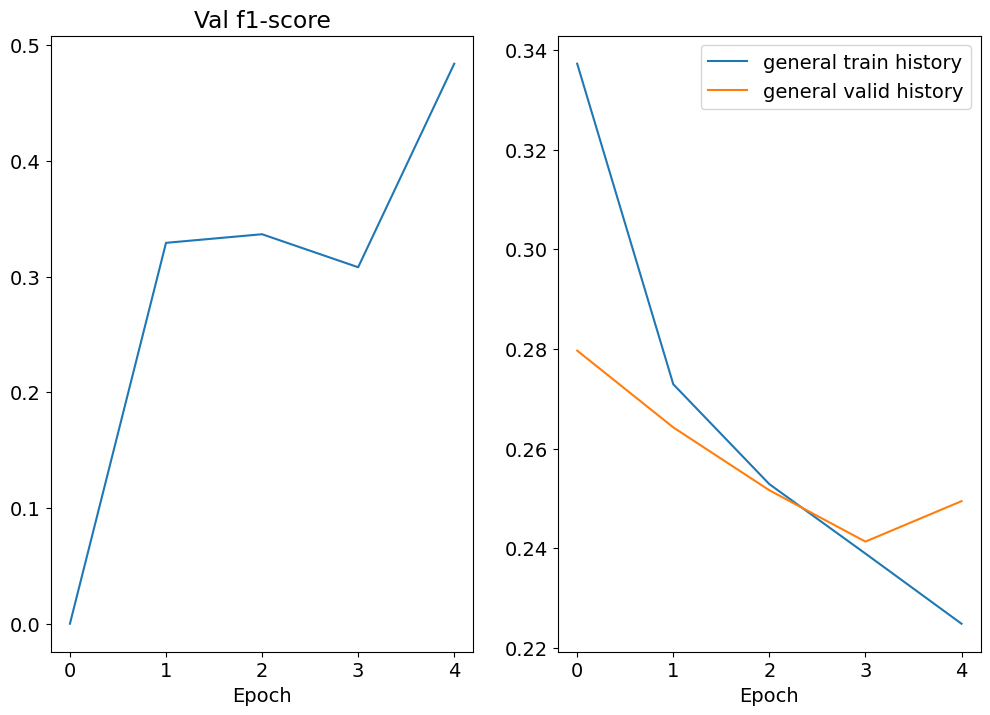

Epoch: 05 | Time: 24m 55s
	Train Loss: 0.225
	 Val. Loss: 0.249 |  Val. F1: 0.484


In [ ]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "bert_linearized_graph_clf", device)

In [ ]:
bert_linearized_graph_clf.load_state_dict(torch.load('best-val-bert_linearized_graph_clf.pt'))

<All keys matched successfully>

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.6281800391389433,0.39362354383813614,0.48398039954768196


### Evaluation on test set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, test_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.6308139534883721,0.3895870736086176,0.4816870144284129


In [ ]:
assert len(true_labels) == len(pred_labels)

In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels


In [ ]:
test_df.head()

,sample_id,subset,question,answerEntity,questionEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,graph,correct,label,linearized_graph,true_y,prediction
0,0,public,Which of the top 5 longest rivers are not located in China?,Wa,People's Republic of China,Nile\Amazon River\Mississippi River\Yenisey,Q4923414,Q148,"Q3392, Q3783, Q1497, Q78707","{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q148', 'id': 0, 'label': 'People's Republic of China'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q4923414', 'id': 1, 'label': 'Wa'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P2936', 'source': 0, 'target': 1, 'label': 'language used'}, {'name_': 'P17', 'source': 1, 'target': 0, 'label': 'country'}]}",False,0.0,"People's Republic of China, country, People's Republic of China People's Republic of China, language used, </s> Wa </s> </s> Wa </s>, country, People's Republic of China",0.0,0
1,1,public,Which Egyptian queen ruled the longest?,Nefertiti,Egyptian,Hatshepsut,Q40930,Q50868,Q129234,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q6173448', 'id': 0, 'label': 'Wikipedia:Vital articles/Level/4'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q50868', 'id': 1, 'label': 'Egyptian'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q40930', 'id': 2, 'label': 'Nefertiti'}], 'links': [{'name_': 'P5008', 'source': 1, 'target': 0, 'label': 'on focus list of Wikimedia project'}, {'name_': 'P5008', 'source': 2, 'target': 0, 'label': 'on focus list of Wikimedia project'}]}",False,0.0,"Egyptian, on focus list of Wikimedia project, Wikipedia:Vital articles/Level/4 </s> Nefertiti </s>, on focus list of Wikimedia project, Wikipedia:Vital articles/Level/4",0.0,0
2,2,private,Which game in Animal Crossing series sold the most copies?,Category:Animal Crossing,Animal Crossing,Animal Crossing: New Horizons,Q8253315,Q1139803,Q64566657,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q1139803', 'id': 0, 'label': 'Animal Crossing'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q8253315', 'id': 1, 'label': 'Category:Animal Crossing'}], 'links': [{'name_': 'P910', 'source': 0, 'target': 1, 'label': 'topic's main category'}, {'name_': 'P301', 'source': 1, 'target': 0, 'label': 'category's main topic'}]}",False,0.0,"Animal Crossing, topic's main category, </s> Category:Animal Crossing </s> </s> Category:Animal Crossing </s>, category's main topic, Animal Crossing",0.0,0
3,3,public,Who is the actor that played John Kramer in Saw?,Category:Saw (franchise),John Kramer\Saw,Tobin Bell,Q8706244,"Q12320195, Q1145690",Q310190,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q6581097', 'id': 0, 'label': 'male'}, {'type': 'INTERNAL', 'name_': 'Q31', 'id': 1, 'label': 'Belgium'}, {'type': 'INTERNAL', 'name_': 'Q35', 'id': 2, 'label': 'Denmark'}, {'type': 'INTERNAL', 'name_': 'Q4167836', 'id': 3, 'label': 'Wikimedia category'}, {'type': 'INTERNAL', 'name_': 'Q312051', 'id': 4, 'label': 'Ken Leung'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1145690', 'id': 5, 'label': 'Saw'}, {'type': 'INTERNAL', 'name_': 'Q486239', 'id': 6, 'label': 'Saw'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q8706244', 'id': 7, 'label': 'Category:Saw (franchise)'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q12320195', 'id': 8, 'label': 'John Kramer'}], 'links': [{'name_': 'P530', 'source': 2, 'target': 1, 'label': 'diplomatic relation'}, {'name_': 'P1963', 'source': 3, 'target': 1, 'label': 'properties for this type'}, {'name_': 'P21', 'source': 4, 'target': 0, 'label': 'sex or gender'}, {'name_': 'P910', 'source': 5, 'target': 7, 'label': 'topic's main category'}, {'name_': 'P161', 'source': 6, 'target': 4, 'label': 'cast member'}, {'name_': 'P179', 'source': 6, 'target': 5, 'label': 'part of the series'}, {'name_': 'P910', 'source': 6, 'target': 7, 'label': 'topic's main category'}, {'name_': 'P31', 'source': 7, 'target': 3, 'label': 'instance of'}, {'name_': 'P301', 'source': 7, 'target': 5, 'label': 'category's main topic'}, {'name_

In [ ]:
test_df[["question", "answerEntity", "groundTruthAnswerEntity", "true_y", "prediction", "label"]].head(50)

,question,answerEntity,groundTruthAnswerEntity,true_y,prediction,label
0,Which of the top 5 longest rivers are not located in China?,Wa,Nile\Amazon River\Mississippi River\Yenisey,0.0,0,0.0
1,Which Egyptian queen ruled the longest?,Nefertiti,Hatshepsut,0.0,0,0.0
2,Which game in Animal Crossing series sold the most copies?,Category:Animal Crossing,Animal Crossing: New Horizons,0.0,0,0.0
3,Who is the actor that played John Kramer in Saw?,Category:Saw (franchise),Tobin Bell,0.0,0,0.0
4,What was the first Mass Effect game to include Thane Krios?,PlayStation 4,Mass Effect 2,0.0,0,0.0
5,What is the name of Katniss Everdeen's sister?,film character,Primrose Everdeen,0.0,0,0.0
6,Which game in the Diablo series sold the most copies?,Template:Diablo series,Diablo III,0.0,0,0.0
7,Who released the album Powerslave?,Compass Point Studios,Iron Maiden,0.0,0,0.0
8,Was Michael Jackson or Prince born first?,Sony Music,Prince,0.0,0,0.0
9,Where is the actress who played Katniss in The Hunger Games from?,Los Angeles,Indian Hills,0.0,0,0.0


In [ ]:
test_pred_path = "test_pred_linearized_graph_baseline.tsv"
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)